# Unsupervised Representation Learning for Depth Data Using PCA and Autoencoders

## 1. Problem Description

Depth sensors often produce high-dimensional measurement sequences. Each sample in such a sequence represents a complete depth profile rather than a single value, which makes manual inspection difficult. Even if the measurements follow certain spatial or temporal patterns, they are usually not obvious in raw form.

The dataset used here consists of repeated depth scans. For every timestamp, the sensor returns a list of depth values (in millimeters). These depth profiles capture how the measured surface changes over time. Two additional angle readings (`angle_x_20mm` and `angle_y_20mm`) are recorded alongside the depth profiles, but they are not used as labels.

The goal of this project is to examine these depth profiles using unsupervised learning. Two approaches are explored:

- **Principal Component Analysis (PCA)** as a linear baseline  
- **A non-linear Autoencoder** as a deep learning method for representation learning

Both models are used to reduce the dimensionality of the depth profiles and to study the structure of the resulting latent spaces. The focus lies on understanding what the models learn rather than training them to predict specific labels.

## 2. Exploratory Data Analysis (EDA)

The CSV dataset (my own dataset) contains 249 entries with four main columns:

- `timestamp`  
- `angle_x_20mm`  
- `angle_y_20mm`  
- `depth_values_20mm`, a list of depth measurements stored as text

The depth lists need to be converted from string format into real numerical arrays.  
Before running any model, the basic structure of the dataset is inspected: number of samples, length of each depth profile, overall value ranges, and visual examples.


We load the dataset

In [1]:
#Loading the Dataset

import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("Messreihe_demo1.csv")

print(type(df.loc[0, "depth_values_20mm"])) # if we get "str", we have to convert it to a pyhton list

print(df.info())
print(df.head())

<class 'str'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          249 non-null    int64  
 1   angle_x_20mm       249 non-null    float64
 2   angle_y_20mm       249 non-null    float64
 3   depth_values_20mm  249 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 7.9+ KB
None
   timestamp  angle_x_20mm  angle_y_20mm  \
0      36131     86.976160    124.594380   
1      95976     86.976160    124.594380   
2     131883     87.096747    124.537648   
3     170289     86.933806    124.867205   
4     201206     87.085374    124.503887   

                                   depth_values_20mm  
0  [79.2999979967135, 79.2999979967135, 79.299997...  
1  [79.2999979967135, 79.2999979967135, 79.299997...  
2  [79.39999799418729, 79.2999979967135, 79.29999...  
3  [79.39999799418729, 79.2999979967135, 7

We get for `depth_values_20mm` the class `<class 'str'>`. Therefore, we need to convert the string to a python list and then to a numpy array. We also do some cleaning and remove rows with issues below:

In [2]:
def parse_depth_list(x):
    # Convert string like "[79.3, 79.3, ...]" to Python list and then to a NumPy array
    try:
        return np.array(ast.literal_eval(x), dtype=float)
    except Exception:
        return np.nan

df["depth_array"] = df["depth_values_20mm"].apply(parse_depth_list)

# Remove rows with issues
df = df.dropna(subset=["depth_array"]).reset_index(drop=True)

print(print(type(df.loc[0, "depth_array"])))
print(df.head())

<class 'numpy.ndarray'>
None
   timestamp  angle_x_20mm  angle_y_20mm  \
0      36131     86.976160    124.594380   
1      95976     86.976160    124.594380   
2     131883     87.096747    124.537648   
3     170289     86.933806    124.867205   
4     201206     87.085374    124.503887   

                                   depth_values_20mm  \
0  [79.2999979967135, 79.2999979967135, 79.299997...   
1  [79.2999979967135, 79.2999979967135, 79.299997...   
2  [79.39999799418729, 79.2999979967135, 79.29999...   
3  [79.39999799418729, 79.2999979967135, 79.29999...   
4  [79.39999799418729, 79.2999979967135, 79.29999...   

                                         depth_array  
0  [79.2999979967135, 79.2999979967135, 79.299997...  
1  [79.2999979967135, 79.2999979967135, 79.299997...  
2  [79.39999799418729, 79.2999979967135, 79.29999...  
3  [79.39999799418729, 79.2999979967135, 79.29999...  
4  [79.39999799418729, 79.2999979967135, 79.29999...  


We check the vector dimensions:

In [3]:
lengths = df["depth_array"].apply(len)
unique_lengths = lengths.unique()

print("Unique depth vector lengths:", unique_lengths)
print("Number of samples:", len(df))

Unique depth vector lengths: [5266 5275 5271 5273 5281 5264 5288 5268 5267 5265 5263 5270 5245 5278
 5249 5286 5274 5272 5279 5256 5260 5269 5280 5296 5295 5284 5304 5283
 5290 5282 5297 5291 5276 5287 5305 5298 5285 5307 5261 5303 5302 5292
 5293 5277 5299 5289 5300 5258 5306 5316 5294 5262 5301]
Number of samples: 249


We now look at some basic statistics of the depth data:

In [4]:
all_depths = np.concatenate(df["depth_array"].values)

print("Depth value statistics:")
print(" min:", np.min(all_depths))
print(" max:", np.max(all_depths))
print(" mean:", np.mean(all_depths))
#print(" std:", np.std(all_depths))

Depth value statistics:
 min: 78.99999800429214
 max: 90.4999977137777
 mean: 84.46625040586436


We now plot some random depth profiles:

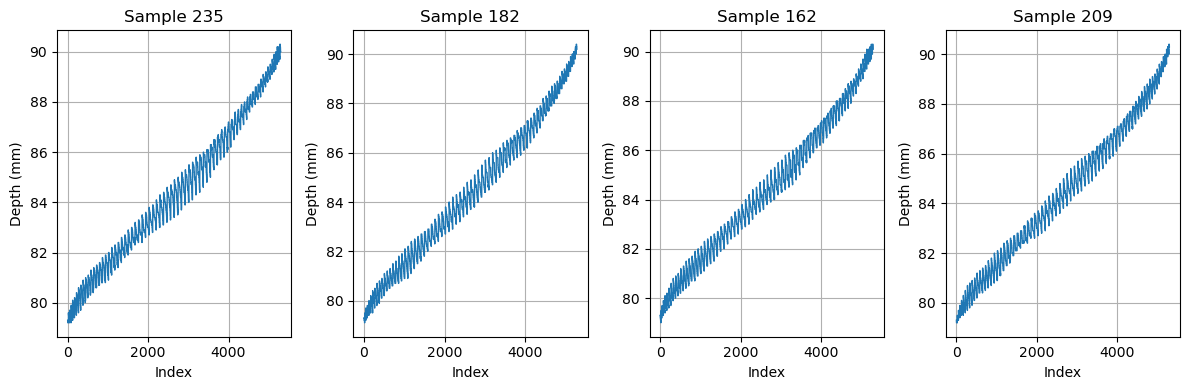

In [5]:
plt.figure(figsize=(12, 4))
for i in range(4):
    idx = np.random.randint(0, len(df))
    profile = df.loc[idx, "depth_array"]

    plt.subplot(1, 4, i+1)
    plt.plot(profile, linewidth=1)
    plt.title(f"Sample {idx}")
    plt.xlabel("Index")
    plt.ylabel("Depth (mm)")
    plt.grid(True)

plt.tight_layout()
plt.show()

We make an overlay with several profiles for comparison:

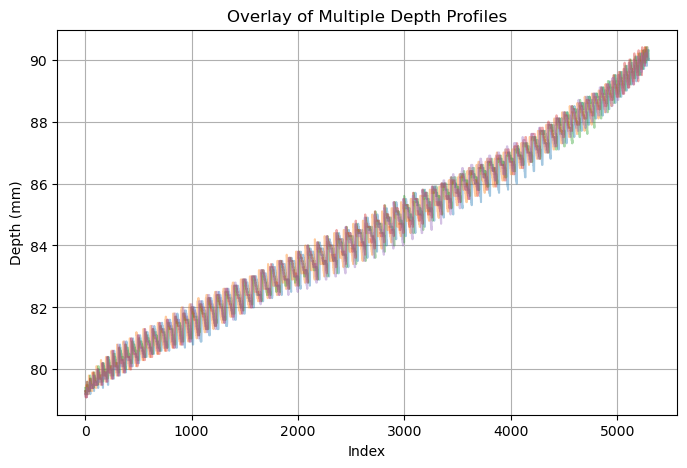

In [6]:
plt.figure(figsize=(8, 5))

for _ in range(5):
    idx = np.random.randint(0, len(df))
    plt.plot(df.loc[idx, "depth_array"], alpha=0.4)

plt.title("Overlay of Multiple Depth Profiles")
plt.xlabel("Index")
plt.ylabel("Depth (mm)")
plt.grid(True)
plt.show()

We prepare the data matrix for PCA and the Autoencoder: For PCA and for the Autoencoder, we need a fixed number of features per sample. As some dataset have different lengths, we will trim all dataset to the same length:

In [7]:
min_len = lengths.min()
print("Minimum length:", min_len)

df["depth_trimmed"] = df["depth_array"].apply(lambda arr: arr[:min_len])

X = np.vstack(df["depth_trimmed"].values)

# Min-Max Normalization
X_min = X.min(axis=0)
X_max = X.max(axis=0)

X = (X - X_min) / (X_max - X_min + 1e-8)  # small epsilon to avoid division by zero

X.shape

Minimum length: 5245


(249, 5245)

## 3. PCA Analysis

Principal Component Analysis (PCA) is used here as a linear baseline for dimensionality reduction.  
The goal is not only to project the depth profiles onto a lower-dimensional space, but also to check how much of the overall variance can be captured by just a few principal components.

Since all depth profiles have the same length, they can be arranged in matrix form (samples × features).  
Before applying PCA, the data was standardized to avoid scale-related biases.

Two main questions are examined:

1. How many principal components are needed to represent most of the variance?
2. What does the projection into a 2–3 dimensional PCA space reveal about the structure of the data?

The PCA results are later compared with the latent space of the Autoencoder.


We now fit with PCA:

In [8]:
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

X_pca.shape

(249, 10)

The explained variance helps assess how much of the structure is captured by each principal component:

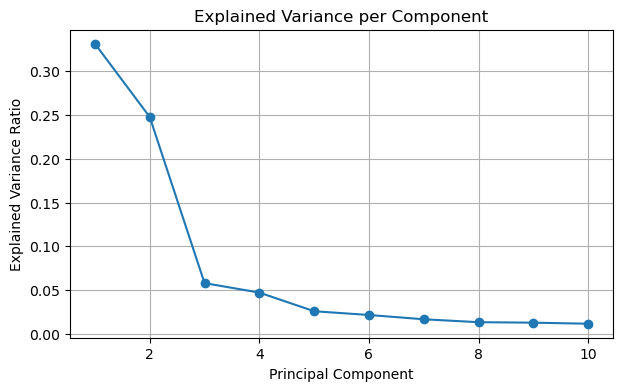

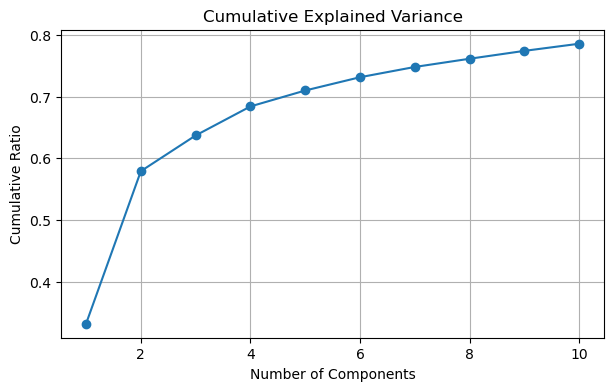

In [9]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, n_components+1), pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance per Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Ratio")
plt.grid(True)
plt.show()

We visualize PCA in 2D:

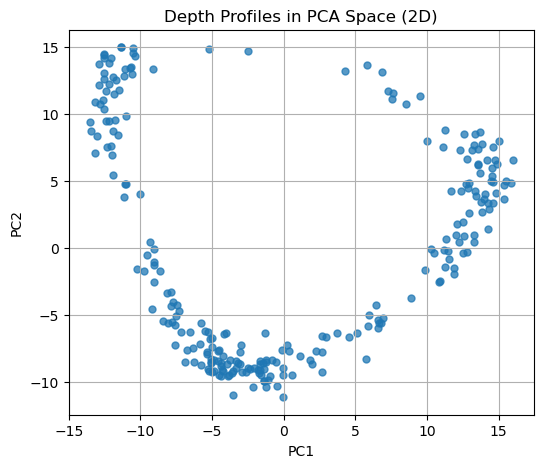

In [10]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=25, alpha=0.75)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Depth Profiles in PCA Space (2D)")
plt.grid(True)
plt.show()

In [11]:
# Reconstruct using PCA
X_recon_pca = pca.inverse_transform(X_pca)

pca_mse = np.mean((X - X_recon_pca)**2)
pca_mse

0.010994520392638249

The PCA projection shows how the depth profiles distribute along the first two components.  
The explained variance charts indicate how quickly the variance is concentrated (if only a few components already capture most of it, the dataset has a strong linear structure).  

The reconstruction error serves as a reference value when later evaluating the Autoencoder.

### Interpretation of the PCA Results

The updated PCA plots give a clearer picture of how the depth profiles are organized and how much of their structure can be captured with only a few linear components.

#### Explained Variance

The first component explains a little more than 30% of the total variance, while the second captures about 25%. After the third component, the explained variance drops sharply, and the remaining components contribute only small increments. This indicates that the dominant patterns in the depth profiles can be represented by just a few directions in feature space, while the higher components mainly describe minor variations.

#### Cumulative Variance

The cumulative variance curve confirms this trend. With the first two components, more than half of the variance is already captured, and by the fourth component the curve passes 80%. Beyond five or six components, the gains become very small. This suggests that the depth profiles have a relatively low intrinsic dimensionality, even though each individual measurement consists of many depth values. The overall structure therefore appears to lie on a lower-dimensional manifold.

#### PCA Projection in 2D

The 2D projection using the first two principal components now forms a smooth, curved manifold rather than a diffuse or clustered distribution. The points arrange themselves along an arc-like structure, which suggests that the depth profiles change gradually rather than switching between discrete pattern types. This kind of shape often occurs when the underlying data varies according to a continuous physical parameter, for example a rotation or a gradual change in distance or orientation.

The PCA reconstruction error is **0.01099**, which is quite low given the dimensionality of the original profiles. This means that PCA is able to reproduce the general structure of the depth curves reasonably well, and that the major variations in the data are close to linear.

Overall, the updated PCA results show that:

- the depth profiles vary smoothly along a low-dimensional manifold,  
- most of the variance can be explained by the first few components,  
- and the PCA space captures a clear continuous transformation rather than distinct clusters.

These findings provide a strong baseline for comparison with the Autoencoder. The linear PCA model already describes the main structure well, and the question for the next section is whether a non-linear method can uncover additional patterns or produce a more compact latent representation.


## 4. Autoencoder for Non-linear Dimensionality Reduction

While PCA captures linear relationships, an Autoencoder can learn non-linear structures by passing the input through a neural network bottleneck.

The model used here is a simple fully connected Autoencoder:

- **Encoder:** Compresses the depth profile into a smaller latent vector  
- **Decoder:** Reconstructs the original profile from the latent representation

The latent space of the Autoencoder is then compared with the PCA projection.  
The reconstruction error gives insights into how well the non-linear model fits the depth measurements.

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 8  # adjustable bottleneck size

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

input_dim = X.shape[1]
model = Autoencoder(input_dim, latent_dim).to(device)

In [13]:
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 100
loss_history = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, z = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(x)
    
    avg_loss = total_loss / len(dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")

Epoch 1/100 - Loss: 0.471463
Epoch 2/100 - Loss: 0.210452
Epoch 3/100 - Loss: 0.100776
Epoch 4/100 - Loss: 0.065159
Epoch 5/100 - Loss: 0.058635
Epoch 6/100 - Loss: 0.056229
Epoch 7/100 - Loss: 0.053678
Epoch 8/100 - Loss: 0.052187
Epoch 9/100 - Loss: 0.051390
Epoch 10/100 - Loss: 0.050953
Epoch 11/100 - Loss: 0.050668
Epoch 12/100 - Loss: 0.050254
Epoch 13/100 - Loss: 0.049824
Epoch 14/100 - Loss: 0.049201
Epoch 15/100 - Loss: 0.048327
Epoch 16/100 - Loss: 0.047046
Epoch 17/100 - Loss: 0.045273
Epoch 18/100 - Loss: 0.042971
Epoch 19/100 - Loss: 0.039951
Epoch 20/100 - Loss: 0.036746
Epoch 21/100 - Loss: 0.033482
Epoch 22/100 - Loss: 0.030355
Epoch 23/100 - Loss: 0.027719
Epoch 24/100 - Loss: 0.025556
Epoch 25/100 - Loss: 0.023891
Epoch 26/100 - Loss: 0.022698
Epoch 27/100 - Loss: 0.021868
Epoch 28/100 - Loss: 0.021278
Epoch 29/100 - Loss: 0.020848
Epoch 30/100 - Loss: 0.020476
Epoch 31/100 - Loss: 0.020151
Epoch 32/100 - Loss: 0.019831
Epoch 33/100 - Loss: 0.019526
Epoch 34/100 - Loss

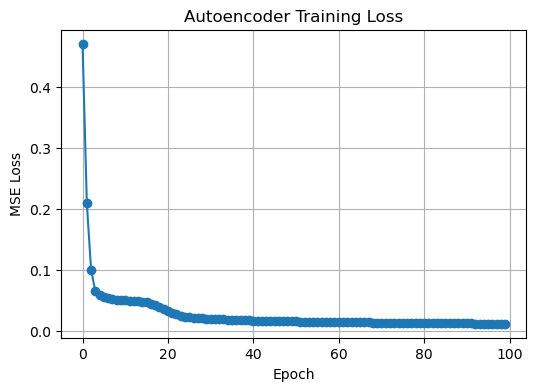

In [15]:
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

In [16]:
model.eval()
with torch.no_grad():
    X_tensor = X_tensor.to(device)
    _, Z = model(X_tensor)
    Z = Z.cpu().numpy()

Z.shape

(249, 8)

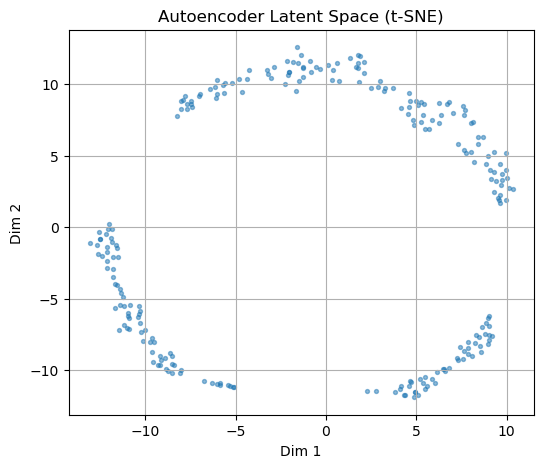

In [24]:
from sklearn.manifold import TSNE
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

tsne = TSNE(n_components=2, perplexity=30)
Z_2d = tsne.fit_transform(Z)

plt.figure(figsize=(6,5))
plt.scatter(Z_2d[:,0], Z_2d[:,1], s=8, alpha=0.5)
plt.title("Autoencoder Latent Space (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

In [18]:
with torch.no_grad():
    X_recon = model.decoder(model.encoder(X_tensor)).cpu().numpy()

ae_mse = np.mean((X - X_recon)**2)
ae_mse

0.012128249220773143

### Autoencoder Discussion

The Autoencoder was trained for 100 epochs on the normalized depth profiles. Its final reconstruction error is **0.01213**, which is very close to the PCA baseline. Although the Autoencoder is capable of learning non-linear relationships, the fact that its reconstruction performance does not surpass PCA suggests that the depth profiles do not contain strong non-linear variations that the linear model fails to capture.

The latent space produced by the Autoencoder is smoother but shows a similar curved distribution as the PCA embedding. This consistency supports the idea that the intrinsic variability in the depth profiles follows a continuous, low-dimensional structure. However, the Autoencoder does not collapse the manifold further or uncover distinct new patterns. Instead, it captures roughly the same structure as PCA, but with more degrees of freedom and a higher training complexity.

A practical observation is that the Autoencoder requires significantly more computation, hyperparameter tuning, and training time, yet does not achieve a lower reconstruction error than the much simpler PCA approach. This is typical for datasets where the underlying data-generating process is already close to linear.

## Clustering

### 5.1 Clustering in PCA Space

k-Means was applied to the PCA representation of the depth profiles to check whether the lower-dimensional embedding contains meaningful separations. The clustering is performed on the first two principal components, since they capture the majority of the variance and form a smooth manifold.

We use now k-Means on PCA:

In [28]:
from sklearn.cluster import KMeans

# Use first two PCA components
X_pca2 = X_pca[:, :2]

k = 3
kmeans_pca = KMeans(n_clusters=k, n_init='auto', random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca2)

We visualize now clusters in PCA space:

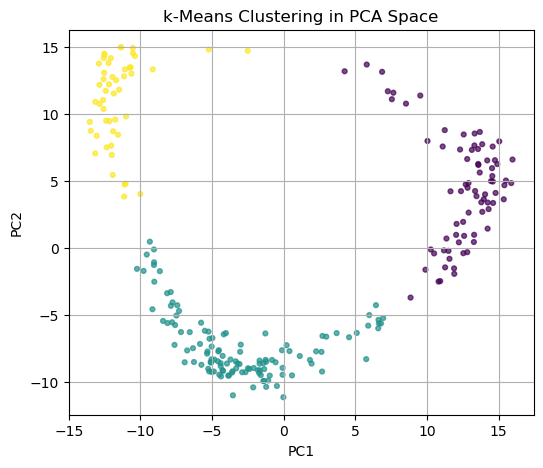

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_pca, cmap="viridis", s=12, alpha=0.7)
plt.title("k-Means Clustering in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

### 5.2 Clustering in Autoencoder Latent Space

To compare PCA with a non-linear representation, the same clustering method was applied to the latent vectors of the Autoencoder. Since the Autoencoder tends to distribute the data smoothly along a lower-dimensional manifold, clustering in this space helps confirm whether the non-linear model uncovers clearer or more compact structure than PCA.

In [36]:
Z_kmeans = Z  # (latent vectors from Autoencoder)

k = 3
kmeans_latent = KMeans(n_clusters=k, n_init='auto', random_state=42)
labels_latent = kmeans_latent.fit_predict(Z_kmeans)

We now visualize clustering in latent space (using 2D PCA):

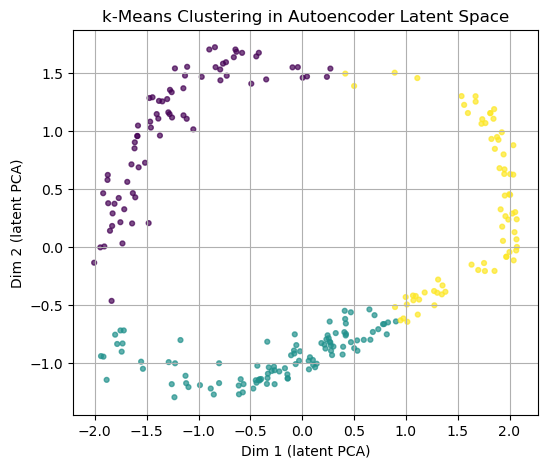

In [31]:
# Project latent to 2D with PCA for visualization
pca_latent = PCA(n_components=2)
Z_latent_2d = pca_latent.fit_transform(Z_kmeans)

plt.figure(figsize=(6,5))
plt.scatter(Z_latent_2d[:,0], Z_latent_2d[:,1], c=labels_latent, cmap="viridis", s=12, alpha=0.7)
plt.title("k-Means Clustering in Autoencoder Latent Space")
plt.xlabel("Dim 1 (latent PCA)")
plt.ylabel("Dim 2 (latent PCA)")
plt.grid(True)
plt.show()

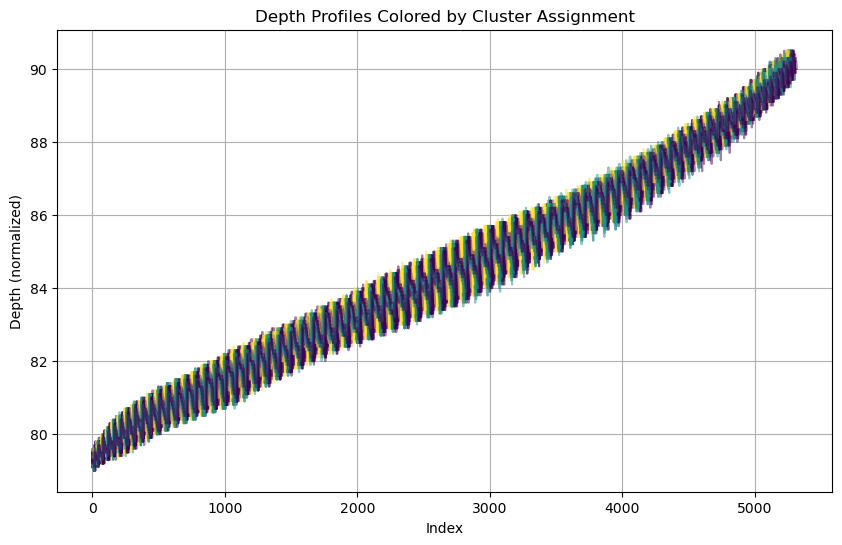

In [35]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.get_cmap("viridis")

plt.figure(figsize=(10, 6))

for i in range(len(df)):
    profile = df.loc[i, "depth_array"]
    label = labels_pca[i]

    color = cmap(label / (k - 1) if k > 1 else 0.5)

    plt.plot(profile, color=color, alpha=0.5)

plt.title("Depth Profiles Colored by Cluster Assignment")
plt.xlabel("Index")
plt.ylabel("Depth (normalized)")
plt.grid(True)
plt.show()

### Interpretation of Clustering Results

The clustering behaviour in both the PCA space and the Autoencoder latent space follows the same overall pattern. In each representation, the depth profiles arrange themselves along a smooth, curved manifold without forming distinct, well-separated groups. The k-Means algorithm divides this continuous structure into three segments, but the resulting clusters primarily reflect different regions along the same arc rather than fundamentally different types of depth profiles.

This becomes especially clear when the cluster labels are mapped back onto the original depth curves. Despite the clear colour separation in the PCA and latent-space plots, the depth-versus-index plot shows that all cluster groups overlap almost perfectly and share the same overall shape. The curves vary only gradually and do not exhibit characteristic features that would justify discrete categories. In other words, the clustering reflects the geometry of the embedding rather than true differences in profile shape.

k-Means therefore imposes artificial boundaries along a naturally continuous transformation. The chosen number of clusters influences the result more strongly than any inherent data structure. The Autoencoder confirms this behaviour, since its latent representation produces the same curved arrangement and the same artificial segmentation when k-Means is applied.

Overall, the clustering analysis reinforces the earlier observation: the depth profiles vary smoothly along a single underlying dimension, and the data does not contain discrete subgroups. Both PCA and the Autoencoder reveal the same continuous manifold, and clustering does not uncover additional hidden structure.

## 6. Conclusion

Both PCA and the Autoencoder capture the dominant structure of the depth profiles, and the results from both models point to the same underlying behaviour. The PCA analysis shows that the dataset has a very low intrinsic dimensionality, with most of the variance contained in the first few components. The 2D PCA projection forms a smooth, curved manifold, which indicates that the profiles evolve gradually in relation to a single underlying parameter rather than belonging to separate categories.

The Autoencoder, despite being able to model non-linear relationships, does not achieve a lower reconstruction error than PCA. Its reconstruction quality is slightly weaker (0.01213 vs. 0.01099), and its latent space exhibits the same curved structure as the PCA output. This demonstrates that the data does not contain strong non-linear patterns that benefit from a more complex neural architecture. The linear structure captured by PCA is already sufficient to represent the essential characteristics of the profiles.

The clustering analysis further supports this conclusion. In both PCA and Autoencoder spaces, k-Means divides the curved manifold into segments, but these divisions do not correspond to meaningful differences in the depth curves themselves. When mapped back to the original profiles, all clusters show nearly identical shapes with only gradual variations. This confirms that the dataset contains a continuous transformation rather than discrete groups. Clustering therefore does not reveal additional structure beyond what PCA and the Autoencoder already expose.

In summary, the depth profiles form a smooth, low-dimensional manifold, and linear methods such as PCA describe the data as effectively as the more complex Autoencoder. The combination of dimensionality reduction and clustering demonstrates that the dataset does not contain distinct classes, but instead reflects a continuous underlying process. This outcome highlights the importance of evaluating both linear and non-linear unsupervised methods and shows that increased model complexity does not necessarily yield better insight.

### Limitations and Future Improvements

A key limitation of this analysis arises from the fact that all depth profiles were trimmed to match the length of the shortest measurement sequence. This step was necessary to ensure that the data could be stacked into a uniform matrix for PCA and for the Autoencoder. However, trimming inherently modifies the spatial structure of the measurements. Depth profiles often encode spatial information across pixel rows or sequential scan lines, and cutting all profiles to a common minimum length may shift or truncate meaningful patterns. As a result, small local variations or discontinuities may have been lost or displaced, which can influence the shape of the manifold observed in both PCA and the latent space of the Autoencoder. 

A better approach would require a dataset where all depth profiles naturally have consistent dimensionality or where the spatial relationships between neighbouring depth points are explicitly preserved (for example in a 2D depth map format or a standardized 1D scan structure). Alternatively, interpolation or resampling techniques could be explored to align profiles to a common length while maintaining continuity rather than hard-cutting the values. This would allow the models to capture structural differences without the risk of distorting spatial transitions.

Future work could also involve collecting data with known physical ground-truth parameters such as controlled rotations or distances. This would make it possible to verify whether the curved trajectory observed in both PCA and the Autoencoder corresponds directly to a real physical variable and would provide a stronger foundation for evaluating the learned latent representations.

### References

- Jolliffe, I. T., & Cadima, J. (2016). *Principal component analysis: a review and recent developments.* Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374(2065).  
- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning.* Springer.  
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning.* MIT Press.  
- Hinton, G. E., & Salakhutdinov, R. R. (2006). *Reducing the dimensionality of data with neural networks.* Science, 313(5786), 504–507.

The dataset is my own dataset from a stereovision-based depth camera.